## PFT survival
This code shows as simple way to:
- Reads in h1 files using xarray
- Find max monthly LAIs for each PFT and calculates 'survival'
- Uses facetgrid to plot max LAI that highlights dead grids
  
uses sparse grid example from ESDS
https://ncar.github.io/esds/posts/2022/sparse-PFT-gridding/

#### Import Libraries

In [1]:
import re
import os
import time
import datetime
import calendar
import tqdm
import cftime
import dask

#from ctsm_py import utils
from netCDF4 import num2date
from glob import glob
from os.path import join

import numpy as np
import pandas as pd
import xarray as xr

# some resources for plotting
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
%matplotlib inline

# some nice plotting settings
#xr.set_options(cmap_sequential=mpl.cm.YlGn, keep_attrs=True)
plt.rcParams["figure.dpi"] = 120
cbar_kwargs = {"orientation": "horizontal", "shrink": 0.8, "aspect": 30}


def setup_axes():
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    return ax

In [2]:
## This is in utils, but will load it here too
def time_set_mid(ds, time_name, deep=False):
    """
    Return copy of ds with values of ds[time_name] replaced with midpoints of
    ds[time_name].attrs['bounds'], if bounds attribute exists.
    Except for time_name, the returned Dataset is a copy of ds2.
    The copy is deep or not depending on the argument deep.
    """

    ds_out = ds.copy(deep)

    if "bounds" not in ds[time_name].attrs:
        return ds_out

    tb_name = ds[time_name].attrs["bounds"]
    tb = ds[tb_name]
    bounds_dim = next(dim for dim in tb.dims if dim != time_name)

    # Use da = da.copy(data=...), in order to preserve attributes and encoding.

    # If tb is an array of datetime objects then encode time before averaging.
    # Do this because computing the mean on datetime objects with xarray fails
    # if the time span is 293 or more years.
    #     https://github.com/klindsay28/CESM2_coup_carb_cycle_JAMES/issues/7
    if tb.dtype == np.dtype("O"):
        units = "days since 0001-01-01"
        calendar = "noleap"
        tb_vals = cftime.date2num(ds[tb_name].values, units=units, calendar=calendar)
        tb_mid_decode = cftime.num2date(
            tb_vals.mean(axis=1), units=units, calendar=calendar
        )
        ds_out[time_name] = ds[time_name].copy(data=tb_mid_decode)
    else:
        ds_out[time_name] = ds[time_name].copy(data=tb.mean(bounds_dim))

    return ds_out

----
### Read in h1 data to look at PFT survival

Single variable time series can be made with the following:

`ncrcat -v TLAI,pfts*,lat,lon,area,landfrac ctsm53017_f19_BNF_hist.clm2.h1.192* /glade/derecho/scratch/wwieder/ctsm53017_f19_BNF_hist.clm2.h1.TLAI.1920s.nc`

In [3]:
cases = ['ctsm530_f19_PPE_hist', 'ctsm530_f19_nfix_param2_hist',
         'ctsm53026_BNF_hist']
cases_short = ['CLM53_PPE', 'NFIX + Param*', 'PPEv3']
c = 1          # select the case to plot
var = 'TLAI'
file = '.clm2.h1.'+var+'.185*.nc'
path = '/glade/derecho/scratch/oleson/timeseries/'+cases[c]+'/lnd/proc/tseries/month_1/'
#path1 = '/glade/derecho/scratch/wwieder/'+cases[c]+'/run/'
fin = []
fin.extend(sorted(glob(join(path+cases[c]+file))))


### Hard coded for my hacked job...
c = 5          # select the case to plot
cases = ['ctsm53n04ctsm52028_f09_hist',
         '#89_ctsm53019_f09_BNF_hist',
         '#91_ctsm53026_BNF_hist',
         '#98_ctsm53041_54surfdata_HIST',
         '#99_ctsm53041_glcMods_HIST',
         '#101_ctsm53041_PPEbaseline_HIST',
         '#103__ctsm53041_PPEcal23_HIST',
         '#104__ctsm53041_PPEcal25_HIST',
         '#105__ctsm53041_PPEcal27_HIST',
         '#106__ctsm53041_PPEcal30_HIST',
         '#107__ctsm53041_PPEcal32_HIST',
        ]
cases_short = ['CLM53_PPE', 'CLM53_NEW','CLM5.3_PPEv3','CLM5.4_baseline',
              'PPE_baseline','PPE_cal23', 'PPE_cal25', 'PPE_cal27',
               'PPE_cal30', 'PPE_cal32',
              ]
scratch = '/glade/derecho/scratch/wwieder/'
fin = ['ctsm53n04ctsm52028_f09_hist.clm2.h1.TLAI.1860s.nc',
       'ctsm53019_f09_BNF_hist.clm2.h1.TLAI.1860s.nc',
       'ctsm53026_BNF_hist.clm2.h1.TLAI.1850s.nc',
       'ctsm53041_54surfdata_098_HIST.clm2.h1.TLAI.1850s.nc',
       'ctsm53041_54surfdata_glcMods_099_HIST.clm2.h1.1850s.nc',
       'ctsm53041_54surfdata_PPEbaseline_101_HIST.clm2.h1.TLAI.1850s.nc',
       'ctsm53041_54surfdata_PPEcal23_103_HIST.clm2.h1.TLAI.1850s.nc',
       'ctsm53041_54surfdata_PPEcal25_104_HIST.clm2.h1.TLAI.1850s.nc',
       'ctsm53041_54surfdata_PPEcal27_105_HIST.clm2.h1.TLAI.1850s.nc',
       'ctsm53041_54surfdata_PPEcal30_106_HIST.clm2.h1.TLAI.1850s.nc',
       'ctsm53041_54surfdata_PPEcal32_107_HIST.clm2.h1.TLAI.1850s.nc',
      ]
# Open datasets, loading into memory here to avoid using dask
#ds_in = time_set_mid(xr.open_mfdataset(fin[c], decode_times=True), 'time').max('time')
ds_in = xr.open_mfdataset(scratch +fin[c], decode_times=True).max('time')
ds_in

ds_base = time_set_mid(xr.open_mfdataset(scratch+fin[5], decode_times=True), 'time').max('time')
print('ds loaded')

ds loaded


In [4]:
pft_constants = xr.open_dataset(
    '/glade/campaign/cesm/cesmdata/cseg/inputdata/lnd/clm2/paramdata/ctsm60_params.c241017.nc')
pftnames = pft_constants.pftname

In [5]:
ds_in

<xarray.Dataset>
Dimensions:             (nbnd: 2, lon: 144, lat: 96, pft: 119442)
Coordinates:
  * lon                 (lon) float32 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
  * lat                 (lat) float32 -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
Dimensions without coordinates: nbnd, pft
Data variables: (12/18)
    time_bounds         (nbnd) object dask.array<chunksize=(2,), meta=np.ndarray>
    area                (lat, lon) float32 dask.array<chunksize=(96, 144), meta=np.ndarray>
    landfrac            (lat, lon) float32 dask.array<chunksize=(96, 144), meta=np.ndarray>
    pfts1d_lon          (pft) float64 dask.array<chunksize=(119442,), meta=np.ndarray>
    pfts1d_lat          (pft) float64 dask.array<chunksize=(119442,), meta=np.ndarray>
    pfts1d_ixy          (pft) float64 dask.array<chunksize=(119442,), meta=np.ndarray>
    ...                  ...
    pfts1d_wtcol        (pft) float64 dask.array<chunksize=(119442,), meta=np.ndarray>
    pfts1d_itype_veg    (pft) float64 dask.array<chunksize=(119442,), meta=np.ndarray>
    pfts1d_itype_col    (pft) float64 dask.array<chunksize=(119442,), meta=np.ndarray>
    pfts1d_itype_lunit  (pft) float64 dask.array<chunksize=(119442,), meta=np.ndarray>
    pfts1d_active       (pft) float64 dask.array<chunksize=(119442,), meta=np.ndarray>
    TLAI                (pft) float32 dask.array<chunksize=(119442,), meta=np.ndarray>

Our goal here is to expand this 2D GPP dataarray to a 4D sparse array `(time, type, lat, lon)`.

This way no extra memory is used to represent NaNs over the ocean.

We get to work with a substantially simpler representation of the dataset.

We develop the following two functions: to_sparse and convert_pft_variables_to_sparse

In [6]:
def to_sparse(data, vegtype, jxy, ixy, shape):
    """
    Takes an input numpy array and converts it to a sparse array.

    Parameters
    ----------
    data: numpy.ndarray
        1D or 2D Data stored in compressed form.
    vegtype: numpy.ndarray

    jxy: numpy.ndarray
        Latitude index
    ixy: numpy.ndarray
        Longitude index
    shape: tuple
        Shape provided as sizes of (vegtype, jxy, ixy) in uncompressed
        form.

    Returns
    -------
    sparse.COO
        Sparse nD array
    """
    import sparse

    # This constructs a list of coordinate locations at which data exists
    # it works for arbitrary number of dimensions but assumes that the last dimension
    # is the "stacked" dimension i.e. "pft"
    if data.ndim == 1:
        coords = np.stack([vegtype, jxy - 1, ixy - 1], axis=0)
    elif data.ndim == 2:
        # generate some repeated time indexes
        # [0 0 0 ... 1 1 1... ]
        itime = np.repeat(np.arange(data.shape[0]), data.shape[1])
        # expand vegtype and friends for all time instants
        # by sequentially concatenating each array for each time instants
        tostack = [np.concatenate([array] * data.shape[0]) for array in [vegtype, jxy - 1, ixy - 1]]
        coords = np.stack([itime] + tostack, axis=0)
    else:
        raise NotImplementedError

    return sparse.COO(
        coords=coords,
        data=data.ravel(),
        shape=data.shape[:-1] + shape,
        fill_value=np.nan,
    )


def convert_pft_variables_to_sparse(dataset, pftnames):
    """
    Convert 2D PFT variables in dataset to 4D sparse arrays.

    Parameters
    ----------
    dataset: xarray.Dataset
        Dataset with DataArrays that have a `pft` dimension.

    Returns
    -------
    xarray.Dataset
        Dataset whose "PFT" arrays are now sparse arrays
        with `pft` dimension expanded out to (type, lat, lon)
    """

    import sparse
    import xarray as xr

    # extract PFT variables
    pfts = xr.Dataset({k: v for k, v in dataset.items() if "pft" in v.dims})

    # extract coordinate index locations
    ixy = dataset.pfts1d_ixy.astype(int)
    jxy = dataset.pfts1d_jxy.astype(int)
    vegtype = dataset.pfts1d_itype_veg.astype(int)
    npft = len(pftnames.data)

    # expected shape of sparse arrays to pass to `to_sparse` (excludes time)
    output_sizes = {
        "vegtype": npft,
        "lat": dataset.sizes["lat"],
        "lon": dataset.sizes["lon"],
    }

    result = xr.Dataset()
    # we loop over variables so we can specify the appropriate dtype
    for var in pfts:
        result[var] = xr.apply_ufunc(
            to_sparse,
            pfts[var],
            vegtype,
            jxy,
            ixy,
            kwargs=dict(shape=tuple(output_sizes.values())),
            input_core_dims=[["pft"]] * 4,
            output_core_dims=[["vegtype", "lat", "lon"]],
            dask="parallelized",
            dask_gufunc_kwargs=dict(
                meta=sparse.COO(np.array([], dtype=pfts[var].dtype)),
                output_sizes=output_sizes,
            ),
            keep_attrs=True,
        )

    # copy over coordinate variables lat, lon
    result = result.update(dataset[["lat", "lon"]])
    result["vegtype"] = pftnames.data
    # save the dataset attributes
    result.attrs = dataset.attrs
    return result

#### Now convert to gridded output

In [7]:
sparse_data = convert_pft_variables_to_sparse(ds_in, pftnames).load()
#sparse_base = convert_pft_variables_to_sparse(ds_base, pftnames).load()
sparse_data

Format,coo
Data Type,float64
Shape,"(79, 96, 144)"
nnz,96322
Density,0.08819920593061416
Read-only,True
Size,2.9M
Storage ratio,0.35
Format,coo
Data Type,float64
Shape,"(79, 96, 144)"


#### Quick sanity check of results

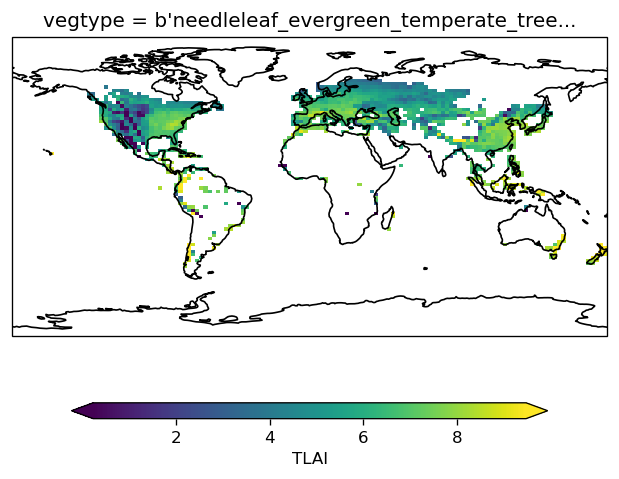

In [8]:
ax = setup_axes()
sparse_data['TLAI'].isel(vegtype=1).plot(robust=True, ax=ax, cbar_kwargs=cbar_kwargs)


### Make facet grid with all pfts


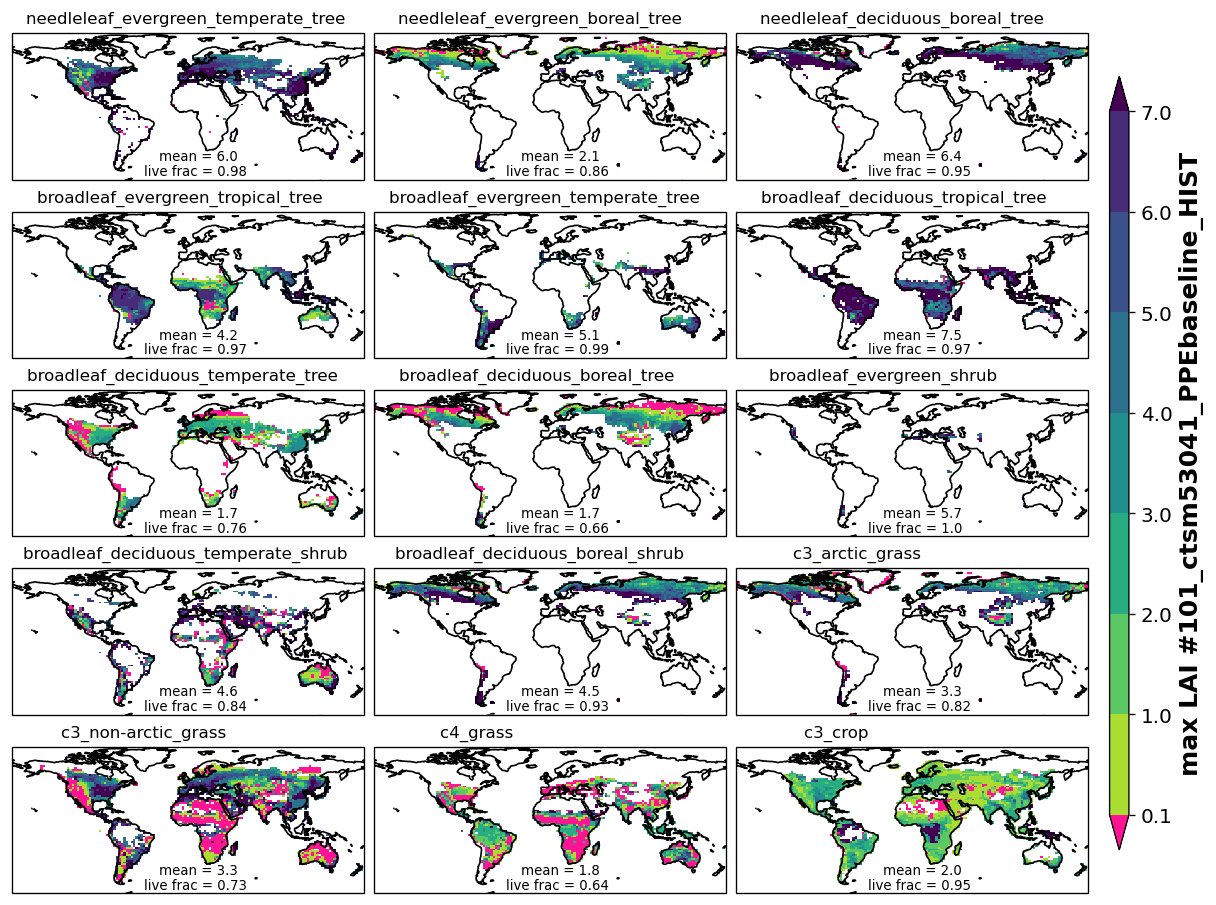

In [9]:
var = 'TLAI'
if var == 'TLAI':
    cmap = plt.cm.viridis_r
    cmap.set_under(color='deeppink')
    levels = [0.1, 1, 2, 3, 4, 5, 6,7]

else:
    cmap = plt.cm.viridis_r
    cmap.set_under(color='white')
    levels = [0.01, .1, .2, .3, .4, .5, .6, .7]

fg = sparse_data[var].isel(vegtype=slice(1, 16)).sel(lat=slice(-65,85)).plot(
    x = "lon", y="lat", col = "vegtype", 
    col_wrap=3, cmap = cmap, levels=levels,
    cbar_kwargs={#"orientation": "vertical", "shrink": 0.8, 
                 #"aspect": 40, "pad": 0.01
    },
    transform = ccrs.PlateCarree(),
    subplot_kws={"projection": ccrs.PlateCarree()},
    add_colorbar=False
)

# Make some custom titles and info for each plot
titles,mean,alive,area = [],[],[],[]
for i in range(1,16):
    titles.append(str(sparse_data.vegtype[i].data)[2:38])
    if var == 'TLAI':
        mean.append('mean = '+str(np.round(sparse_data[var].isel(vegtype=i).mean().values,1)))
        dead = (sparse_data[var].isel(vegtype=i)<0.1).sum()
        live = (sparse_data[var].isel(vegtype=i)>0.1).sum()
        livefrac = str(np.round((live/(live+dead)).values,2))
        alive.append('live frac = '+livefrac)
    else: 
        tempArea = (sparse_data[var].isel(vegtype=i) * ds_in.area * ds_in.landfrac).sum()*1e-6
        area.append(str(np.round(tempArea.values,2))+" (1e6 km2)")

if var == 'TLAI':
    for ax, mean in zip(fg.axs.flat, mean):
        ax.text(-30,-45,mean,fontsize=8)
        
    for ax, alive in zip(fg.axs.flat, alive):
        ax.text(-45,-60,alive,fontsize=8)
else:
    for ax, area in zip(fg.axs.flat, area):
        ax.text(-45,-60,area,fontsize=8)
    
for ax, title in zip(fg.axs.flat, titles):
    ax.set_title(title,fontsize=10)#,loc='left',backgroundcolor = 'white')
for ax in fg.axs.flat:  # loop through the map axes
    ax.coastlines()

#fg.fig.title('test title')

fg.fig.set_layout_engine("compressed")
fg.add_colorbar(pad=0.02, shrink=0.9, aspect=40)
fg.cbar.ax.tick_params(labelsize=12)
if var == 'TLAI':
    fg.cbar.set_label(label=("max LAI "+cases[c]), size=15, weight='bold')
else:
    fg.cbar.set_label(label=("grid_weights "+cases[c]), size=15, weight='bold')
    
#plt.suptitle(cases[c],ha='center',va='bottom')
#plt.subplots_adjust(top=0.95)
plt.show() ;

-----

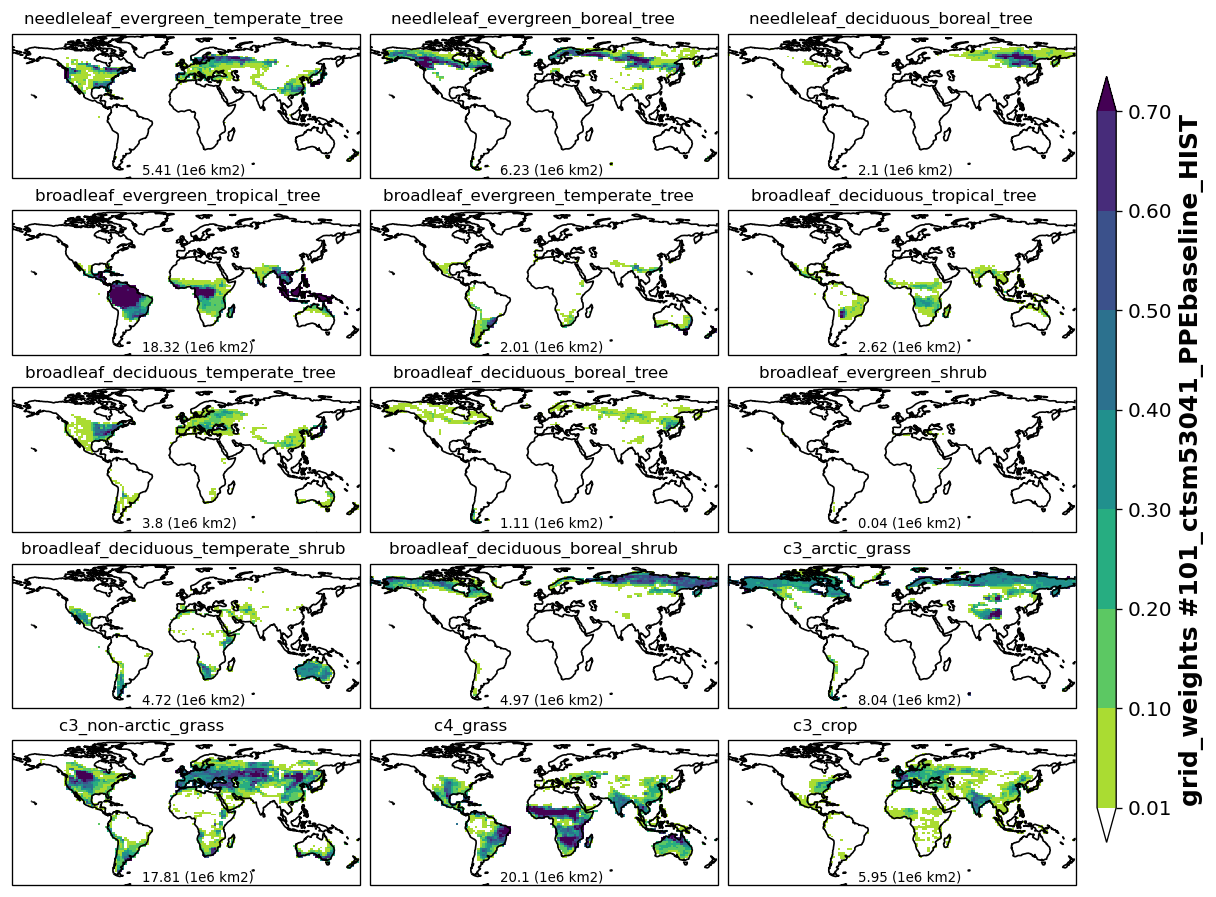

In [12]:
var = 'pfts1d_wtgcell'
if var == 'TLAI':
    cmap = plt.cm.viridis_r
    cmap.set_under(color='deeppink')
    levels = [0.1, 1, 2, 3, 4, 5, 6,7]

else:
    cmap = plt.cm.viridis_r
    cmap.set_under(color='white')
    levels = [0.01, .1, .2, .3, .4, .5, .6, .7]

fg = sparse_data[var].isel(vegtype=slice(1, 16)).sel(lat=slice(-65,85)).plot(
    x = "lon", y="lat", col = "vegtype", 
    col_wrap=3, cmap = cmap, levels=levels,
    cbar_kwargs={#"orientation": "vertical", "shrink": 0.8, 
                 #"aspect": 40, "pad": 0.01
    },
    transform = ccrs.PlateCarree(),
    subplot_kws={"projection": ccrs.PlateCarree()},
    add_colorbar=False
)

# Make some custom titles and info for each plot
titles,mean,alive,area = [],[],[],[]
for i in range(1,16):
    titles.append(str(sparse_data.vegtype[i].data)[2:38])
    if var == 'TLAI':
        mean.append('mean = '+str(np.round(sparse_data[var].isel(vegtype=i).mean().values,1)))
        dead = (sparse_data[var].isel(vegtype=i)<0.1).sum()
        live = (sparse_data[var].isel(vegtype=i)>0.1).sum()
        livefrac = str(np.round((live/(live+dead)).values,2))
        alive.append('live frac = '+livefrac)
    else: 
        tempArea = (sparse_data[var].isel(vegtype=i) * ds_in.area * ds_in.landfrac).sum()*1e-6
        area.append(str(np.round(tempArea.values,2))+" (1e6 km2)")

if var == 'TLAI':
    for ax, mean in zip(fg.axs.flat, mean):
        ax.text(-30,-45,mean,fontsize=8)
        
    for ax, alive in zip(fg.axs.flat, alive):
        ax.text(-45,-60,alive,fontsize=8)
else:
    for ax, area in zip(fg.axs.flat, area):
        ax.text(-45,-60,area,fontsize=8)
    
for ax, title in zip(fg.axs.flat, titles):
    ax.set_title(title,fontsize=10)#,loc='left',backgroundcolor = 'white')
for ax in fg.axs.flat:  # loop through the map axes
    ax.coastlines()

#fg.fig.title('test title')

fg.fig.set_layout_engine("compressed")
fg.add_colorbar(pad=0.02, shrink=0.9, aspect=40)
fg.cbar.ax.tick_params(labelsize=12)
if var == 'TLAI':
    fg.cbar.set_label(label=("max LAI "+cases[c]), size=15, weight='bold')
else:
    fg.cbar.set_label(label=("grid_weights "+cases[c]), size=15, weight='bold')
    
#plt.suptitle(cases[c],ha='center',va='bottom')
#plt.subplots_adjust(top=0.95)
plt.show() ;

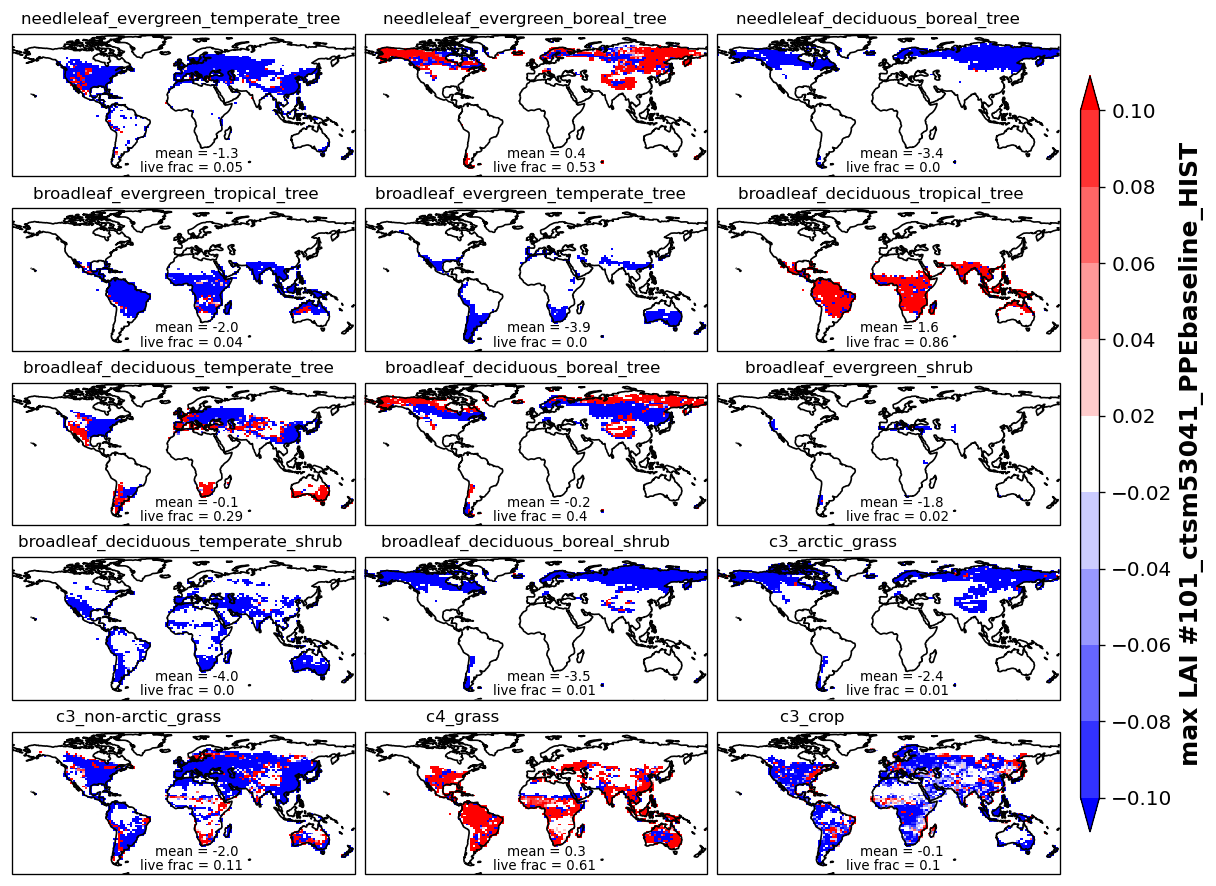

In [29]:
var = 'TLAI'
cmap = plt.cm.bwr
levels = [-0.1,-0.08,-0.06,-0.04,-0.02,0.02,0.04,0.06,0.08,0.1]

sparse_diff = sparse_data - sparse_base
fg = sparse_diff[var].isel(vegtype=slice(1, 16)).sel(lat=slice(-65,85)).plot(
    x = "lon", y="lat", col = "vegtype", 
    col_wrap=3, cmap = cmap, levels=levels,
    cbar_kwargs={#"orientation": "vertical", "shrink": 0.8, 
                 #"aspect": 40, "pad": 0.01
    },
    transform = ccrs.PlateCarree(),
    subplot_kws={"projection": ccrs.PlateCarree()},
    add_colorbar=False
)

# Make some custom titles and info for each plot
titles,mean,alive,area = [],[],[],[]
for i in range(1,16):
    titles.append(str(sparse_diff.vegtype[i].data)[2:38])
    if var == 'TLAI':
        mean.append('mean = '+str(np.round(sparse_diff[var].isel(vegtype=i).mean().values,1)))
        dead = (sparse_diff[var].isel(vegtype=i)<0.1).sum()
        live = (sparse_diff[var].isel(vegtype=i)>0.1).sum()
        livefrac = str(np.round((live/(live+dead)).values,2))
        alive.append('live frac = '+livefrac)
    else: 
        tempArea = (sparse_diff[var].isel(vegtype=i) * ds_in.area * ds_in.landfrac).sum()*1e-6
        area.append(str(np.round(tempArea.values,2))+" (1e6 km2)")

if var == 'TLAI':
    for ax, mean in zip(fg.axs.flat, mean):
        ax.text(-30,-45,mean,fontsize=8)
        
    for ax, alive in zip(fg.axs.flat, alive):
        ax.text(-45,-60,alive,fontsize=8)
else:
    for ax, area in zip(fg.axs.flat, area):
        ax.text(-45,-60,area,fontsize=8)
    
for ax, title in zip(fg.axs.flat, titles):
    ax.set_title(title,fontsize=10)#,loc='left',backgroundcolor = 'white')
for ax in fg.axs.flat:  # loop through the map axes
    ax.coastlines()

#fg.fig.title('test title')

fg.fig.set_layout_engine("compressed")
fg.add_colorbar(pad=0.02, shrink=0.9, aspect=40)
fg.cbar.ax.tick_params(labelsize=12)
if var == 'TLAI':
    fg.cbar.set_label(label=("max LAI "+cases[c]), size=15, weight='bold')
else:
    fg.cbar.set_label(label=("grid_weight diff (5.4-5.3)"), size=15, weight='bold')
    
#plt.suptitle(cases[c],ha='center',va='bottom')
#plt.subplots_adjust(top=0.95)
plt.show() ;